In [1]:
!pip install yfinance numpy pandas matplotlib scikit-learn tensorflow


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math


In [3]:
SYMBOL = "AAPL"
START_DATE = "2018-01-01"
END_DATE = None
SEQUENCE_LEN = 60
TEST_SIZE = 0.2
EPOCHS = 30
BATCH_SIZE = 32
HORIZON = 1


In [4]:
def compute_sma(series, window):
    return series.rolling(window=window).mean()

def compute_ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def compute_rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = (-delta).clip(lower=0)
    ma_up = up.rolling(window=window).mean()
    ma_down = down.rolling(window=window).mean()
    rs = ma_up / (ma_down + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [5]:
def download_data(symbol, start, end=None):
    print("Downloading:", symbol)
    df = yf.download(symbol, start=start, end=end, progress=False)
    return df

df_raw = download_data(SYMBOL, START_DATE, END_DATE)
df_raw.head()


Downloading: AAPL


/tmp/ipython-input-2680027290.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(symbol, start=start, end=end, progress=False)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.341892,40.351262,39.639317,39.850091,102223600
2018-01-03,40.334869,40.878196,40.271640,40.405128,118071600
2018-01-04,40.522217,40.625262,40.299735,40.407462,89738400
2018-01-05,40.983578,41.070228,40.526904,40.618239,94640000
2018-01-08,40.831356,41.126437,40.732992,40.831356,82271200


In [6]:
def add_indicators(df):
    df = df.copy()
    df['SMA_10'] = compute_sma(df['Close'], 10)
    df['SMA_20'] = compute_sma(df['Close'], 20)
    df['EMA_12'] = compute_ema(df['Close'], 12)
    df['EMA_26'] = compute_ema(df['Close'], 26)
    df['RSI_14'] = compute_rsi(df['Close'])
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df

df_feat = add_indicators(df_raw)
df_feat.head()


Price,Close,High,Low,Open,Volume,SMA_10,SMA_20,EMA_12,EMA_26,RSI_14,Return
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2018-01-30,39.103024,39.196699,38.571407,38.765787,184192800,40.810976,40.827604,40.438845,40.617305,31.581796,-0.005894
2018-01-31,39.210743,39.447279,38.992946,39.079596,129915600,40.537674,40.771047,40.249907,40.513115,33.186362,0.002755
2018-02-01,39.292713,39.489433,39.053836,39.149856,188923200,40.268822,40.718939,40.102646,40.422715,31.022300,0.002091
2018-02-02,37.587795,39.063205,37.494120,38.875851,346375200,39.848214,40.572218,39.715746,40.212721,17.122543,-0.043390
2018-02-05,36.648678,38.379355,36.533923,37.259919,290954000,39.367887,40.355473,39.243889,39.948717,15.243538,-0.024985


In [2]:
def create_sequences(df, feature_cols, target_col, seq_len=60, horizon=1):
    X, y = [], []
    values = df[feature_cols].values
    targets = df[target_col].values

    for i in range(seq_len, len(df) - horizon + 1):
        X.append(values[i-seq_len:i])
        y.append(targets[i + horizon - 1])

    return np.array(X), np.array(y)


In [4]:
from sklearn.preprocessing import MinMaxScaler


In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import math


In [9]:

# INDICATOR FUNCTIONS (RUN THIS FIRST)

def compute_sma(series, window):
    return series.rolling(window=window).mean()

def compute_ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def compute_rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = (-delta).clip(lower=0)
    ma_up = up.rolling(window=window).mean()
    ma_down = down.rolling(window=window).mean()
    rs = ma_up / (ma_down + 1e-9)
    rsi = 100 - (100 / (1 + rs))
    return rsi

def add_indicators(df):
    df = df.copy()
    df['SMA_10'] = compute_sma(df['Close'], 10)
    df['SMA_20'] = compute_sma(df['Close'], 20)
    df['EMA_12'] = compute_ema(df['Close'], 12)
    df['EMA_26'] = compute_ema(df['Close'], 26)
    df['RSI_14'] = compute_rsi(df['Close'])
    df['Return'] = df['Close'].pct_change()
    df.dropna(inplace=True)
    return df


In [11]:
import yfinance as yf

SYMBOL = "AAPL"
START_DATE = "2018-01-01"
END_DATE = None

df_raw = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False)
df_raw.head()


/tmp/ipython-input-3830005419.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_raw = yf.download(SYMBOL, start=START_DATE, end=END_DATE, progress=False)


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.341885,40.351254,39.639309,39.850084,102223600
2018-01-03,40.334873,40.878200,40.271644,40.405131,118071600
2018-01-04,40.522213,40.625258,40.299731,40.407458,89738400
2018-01-05,40.983582,41.070231,40.526908,40.618243,94640000
2018-01-08,40.831337,41.126417,40.732973,40.831337,82271200


In [12]:
df_feat = add_indicators(df_raw)
df_feat.head()


Price,Close,High,Low,Open,Volume,SMA_10,SMA_20,EMA_12,EMA_26,RSI_14,Return
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2018-01-30,39.103012,39.196687,38.571396,38.765775,184192800,40.810974,40.827603,40.438842,40.617301,31.581402,-0.005894
2018-01-31,39.210747,39.447283,38.992950,39.079600,129915600,40.537673,40.771046,40.249904,40.513112,33.186255,0.002755
2018-02-01,39.292709,39.489430,39.053833,39.149852,188923200,40.268821,40.718938,40.102643,40.422712,31.022118,0.002090
2018-02-02,37.587795,39.063205,37.494120,38.875851,346375200,39.848212,40.572217,39.715744,40.212718,17.122330,-0.043390
2018-02-05,36.648682,38.379359,36.533926,37.259922,290954000,39.367883,40.355472,39.243888,39.948715,15.243312,-0.024985


In [15]:
KeyError: "['SMA_10', 'EMA_12', ...] not in index"


In [16]:
df_feat.columns


MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL'),
            ('SMA_10',     ''),
            ('SMA_20',     ''),
            ('EMA_12',     ''),
            ('EMA_26',     ''),
            ('RSI_14',     ''),
            ('Return',     '')],
           names=['Price', 'Ticker'])

In [22]:
SEQUENCE_LEN = 60
HORIZON = 1

X, y = create_sequences(
    df_scaled,
    feature_cols,
    target_col,
    seq_len=SEQUENCE_LEN,
    horizon=HORIZON
)


In [24]:
SEQUENCE_LEN = 60
HORIZON = 1
TEST_SIZE = 0.2


In [25]:

SEQUENCE_LEN = 60
HORIZON = 1
TEST_SIZE = 0.2
X, y = create_sequences(
    df_scaled,
    feature_cols,
    target_col,
    seq_len=SEQUENCE_LEN,
    horizon=HORIZON
)

split_idx = int(len(X) * (1 - TEST_SIZE))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]


In [26]:
feature_cols = ['Close', 'Volume', 'SMA_10', 'SMA_20',
                'EMA_12', 'EMA_26', 'RSI_14', 'Return']

target_col = 'Close'

scaler = MinMaxScaler()
df_scaled = df_feat.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_feat[feature_cols])

X, y = create_sequences(df_scaled, feature_cols, target_col,
                        seq_len=SEQUENCE_LEN, horizon=HORIZON)

split_idx = int(len(X) * (1 - TEST_SIZE))

X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

X_train.shape, X_test.shape


((1531, 60, 8), (383, 60, 8))

In [27]:
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(32))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

model = build_lstm((X_train.shape[1], X_train.shape[2]))
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
EPOCHS = 50
BATCH_SIZE = 32


In [30]:
EPOCHS = 50
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=2
)


Epoch 1/50
48/48 - 7s - 142ms/step - loss: 0.0153 - val_loss: 0.0209
Epoch 2/50
48/48 - 4s - 77ms/step - loss: 0.0028 - val_loss: 0.0169
Epoch 3/50
48/48 - 3s - 52ms/step - loss: 0.0023 - val_loss: 0.0223
Epoch 4/50
48/48 - 3s - 53ms/step - loss: 0.0020 - val_loss: 0.0208
Epoch 5/50
48/48 - 3s - 54ms/step - loss: 0.0017 - val_loss: 0.0167
Epoch 6/50
48/48 - 3s - 62ms/step - loss: 0.0014 - val_loss: 0.0189
Epoch 7/50
48/48 - 5s - 98ms/step - loss: 0.0014 - val_loss: 0.0141
Epoch 8/50
48/48 - 3s - 52ms/step - loss: 0.0013 - val_loss: 0.0163
Epoch 9/50
48/48 - 2s - 52ms/step - loss: 0.0011 - val_loss: 0.0146
Epoch 10/50
48/48 - 3s - 69ms/step - loss: 0.0012 - val_loss: 0.0113
Epoch 11/50
48/48 - 4s - 85ms/step - loss: 9.6627e-04 - val_loss: 0.0130
Epoch 12/50
48/48 - 3s - 54ms/step - loss: 0.0011 - val_loss: 0.0201
Epoch 13/50
48/48 - 3s - 55ms/step - loss: 9.7972e-04 - val_loss: 0.0138
Epoch 14/50
48/48 - 3s - 65ms/step - loss: 0.0010 - val_loss: 0.0142
Epoch 15/50
48/48 - 3s - 64ms/step

In [34]:
def inverse_close(arr):
    dummy = np.zeros((len(arr), len(feature_cols)))
    dummy[:, close_idx] = arr.flatten()
    inv = scaler.inverse_transform(dummy)
    return inv[:, close_idx]


In [39]:
def inverse_close(arr):
    """
    Inverse transform only the 'close' column from scaled data.
    Works if arr is shape (N,1) or (N,).
    """
    arr = np.array(arr)
    arr = arr.flatten()

    dummy = np.zeros((len(arr), len(feature_cols)))
    dummy[:, close_idx] = arr

    inv = scaler.inverse_transform(dummy)
    return inv[:, close_idx]


In [41]:
def inverse_close(arr):
    """
    Safely inverse transform only the 'close' column.
    Works whether arr is shape (N,1) or (N,).
    """
    arr = np.array(arr).reshape(-1)
    dummy = np.zeros((len(arr), len(feature_cols)))
    dummy[:, close_idx] = arr
    inv = scaler.inverse_transform(dummy)
    return inv[:, close_idx]


In [42]:
y_test_inv = inverse_close(y_test)
y_pred_inv = inverse_close(y_pred)


In [47]:
rmse = math.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print("RMSE:", rmse)


RMSE: 26.473843261182214


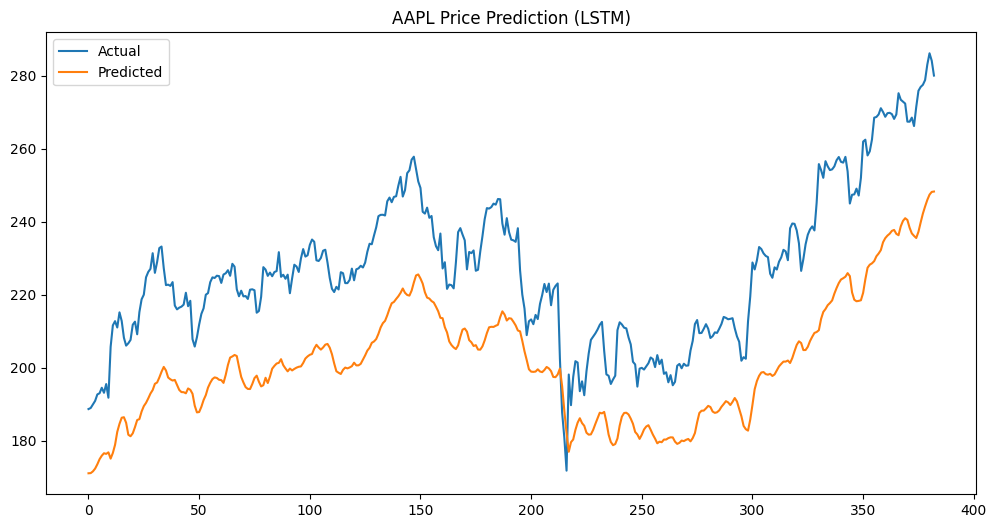

In [48]:
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label="Actual")
plt.plot(y_pred_inv, label="Predicted")
plt.title(f"{SYMBOL} Price Prediction (LSTM)")
plt.legend()
plt.show()


In [49]:
direction_actual = np.sign(np.diff(y_test_inv))
direction_pred = np.sign(np.diff(y_pred_inv))

direction_accuracy = np.mean(direction_actual == direction_pred)
print("Directional Accuracy:", direction_accuracy * 100, "%")


Directional Accuracy: 55.235602094240846 %


In [51]:
model.save("my_model.h5")
